# Implementation of Alpha Zero for our game
This follows the ideas of idea.md

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange

import random
import math

In [9]:


from google.colab import drive
drive.mount('/content/gdrive')


ModuleNotFoundError: No module named 'google'

In [2]:
CONFIGS = {
     "linux-local":{
         "lib_src": "cpp/interface.so"
    },
    
    "colab":{
         "lib_src": "MyDrive/Antelligence/cpp/interface.so"
    },
    "win-local":{
        "lib_src":"cpp/interface.so"
    }
}

CONFIG=CONFIGS["linux-local"]

### OUR GAME

In [3]:

from numpy.ctypeslib import ctypes as ctypes
from abc import ABC, abstractmethod
import os
import numpy as np

EBoardP =ctypes.c_void_p
argType=ctypes.c_int
actionT=ctypes.c_uint16
pointer_action=ctypes.POINTER(actionT)

# FIXME: quando vedi i figli salvali


# Abstract class that implements the game rules
class game_rule(ABC):
    @abstractmethod
    def init_state(self):
        pass
    def next_state(self, state, action:actionT):
        pass
    def checkStatus(self, state):
        pass

# Our game's rules
class DLLGameRule(game_rule):

    MAX_ACTIONS = 1575
    BOARD_VECTOR_SIZE = 32*32

    def __init__(self):
        path = os.path.join(os.getcwd(), CONFIG['lib_src'])
        dll = ctypes.CDLL(path)
        self.dll=dll
        self.getBoard_low = dll._Z10base_statei
        self.copyBoard = dll._Z9copyBoardP6EBoard
        self.updateState_low = dll._Z10next_stateP6EBoardt
        self.checkGameStatus_low = dll._Z11checkStatusP6EBoard
        #self.printAct_low = dll._Z16printActionFancym
        self.PrintBoard_low = dll._Z10printBoardP6EBoard
        self.delBoardC_low=dll._Z8delBoardP6EBoard
        self.stringToAction_low=dll._Z14stringToActionP6EBoardPc
        #self.boardToCVect_low=dll._Z9BoardRappP6EBoard
        self.getStatusVector_low=dll._Z15getStatusVectorP6EBoard
        self.getAssociatedAction_low=dll._Z19getAssociatedActionP6EBoard
        self.getMask_low=self.dll._Z7getMaskP6EBoard
        self.compute_possible_low=self.dll._Z19updatePossiblemovesP6EBoard;
        # Set argument/return types
        self.getBoard_low.argtypes = [argType]  # the type of game, define in engine/enums.h
        self.getBoard_low.restype = EBoardP

        self.copyBoard.argtypes = [EBoardP]
        self.copyBoard.restype = EBoardP

        self.updateState_low.argtypes = [EBoardP, actionT]
        self.updateState_low.restype = None

        self.checkGameStatus_low.argtypes = [EBoardP]
        self.checkGameStatus_low.restype = ctypes.c_int

        self.stringToAction_low.argtypes=[EBoardP,ctypes.c_char_p]
        self.stringToAction_low.restype=actionT

        self.actions = (actionT * self.MAX_ACTIONS)()

        self.getMask_low.argtypes = [ctypes.c_void_p]
        self.getMask_low.restype = ctypes.POINTER(ctypes.c_uint8)

        self.getAssociatedAction_low.argtypes = [ctypes.c_void_p]
        self.getAssociatedAction_low.restype = ctypes.POINTER(actionT)

        self.getStatusVector_low.argtypes = [ctypes.c_void_p]
        self.getStatusVector_low.restype = ctypes.POINTER(actionT)

        self.strBuff=(ctypes.c_char* 30)()

    # Returns the initial state
    def init_state(self,gametype=7) -> EBoardP:
        return self.getBoard_low(gametype)  # default game type  0 ->base, ..., 7 -> MPL


    # Update state given an action. action is a number. Doesn't return anything
    def next_state(self, state:EBoardP, action:actionT): # FIXME: fa l'update della board che ci passi (action come intero)
        self.updateState_low(state, actionT(action))

    # Get the set of possible actions. It is a vector of actions (ints).
    STATUS_OK = 0
    STATUS_INVALID = 1
    STATUS_WHITE_WINS = 2
    STATUS_BLACK_WINS = 3

    # Check if someone has won
    def checkStatus(self, state:EBoardP): # FIXME: ritorna il numero in base a cosa è successo
        code = self.checkGameStatus_low(state)
        status_map = {
            0: "OK",
            1: "INVALID_GAME_NOT_STARTED",
            2: "GAME_OVER_WHITE_WINS or DRAW",
            3: "GAME_OVER_BLACK_WINS",
            4: "GAME_OVER_DRAW"
        }
        return code



    # Prints the board
    def PrintState(self, state:EBoardP): # FIXME: for debug
        self.PrintBoard_low(state)

    # Deletes the board
    def delBoard(self,state:EBoardP):
        self.delBoardC_low(state)

    # Converts the board to a vector of chars (284)
    def toVect(self,state:EBoardP): # FIXME: sarebbe ottimo ritornare un numpy vector di 32*32 CNN 32*32 più altri neuroni (6 in teoria, +1 che rappresenta il turno (è endgame o startgame) +2 che sono i bug mossi appena adesso) che ci dicono chi è sopra a chi e cose del genere
        ptr = self.getStatusVector_low(state)
        arr = np.ctypeslib.as_array(ptr, shape=(1033,))
        return torch.from_numpy(arr.astype(np.float32))

    def toVect_split(self, state: EBoardP) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        ptr = self.getStatusVector_low(state)
        arr = np.ctypeslib.as_array(ptr, shape=(1033,)).astype(np.float32)

        board = torch.from_numpy(arr[:1024]).view(1, 32, 32).to(device)
        metadata = torch.from_numpy(arr[1024:]).to(device)
        return board, metadata

    # Converts a string to an action
    def stringToAction(self,state:EBoardP,str): #FIXME: ritorna un intero
        return self.stringToAction_low(state,str.encode())

    def get_mask(self, state):          # mask for actions
        ptr = self.getMask_low(state)
        return np.ctypeslib.as_array(ptr, shape=(self.MAX_ACTIONS,)).astype(bool)

    def get_actions(self,state):   # all actions masked by getMask
        ptr = self.getAssociatedAction_low(state)
        return np.ctypeslib.as_array(ptr, shape=(self.MAX_ACTIONS,)).astype(np.uint64)

    def compute_actions(self,state:EBoardP):
        self.compute_possible_low(state)

    def get_opponent_value(self, value):
        return -value

    def get_opponent(self, player): # TODO: il player è 1 o -1
        return -player

### Neural Network Model

In [4]:
# Neural network used to output two things: a policy (= probability that from here, doing a certain move gives the winning) and a value (= evaluation of current state)

class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device): # Good = 9,256

        super().__init__()

        self.device = device #GPU

        #Convolution with a 3*3 matrix
        self.startBlock = nn.Sequential(
            nn.Conv2d(1, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        #See ResBlock
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )

        self.board_feat_dim = num_hidden * game.BOARD_VECTOR_SIZE


        self.meta_fc = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.combined_feat_dim = self.board_feat_dim + 64

        #Head for the policy: convolution and linear
        self.policyHead = nn.Sequential(
            nn.Linear(self.combined_feat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, game.MAX_ACTIONS)
        )

        # Value head
        self.valueHead = nn.Sequential(
            nn.Linear(self.combined_feat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x_matrix, x_meta):
        # TODO: x has 6 bugs that are the one that are below the currents, 2 for the just moved ones, and one int for the number of the turn
        # TODO: understand how to integrate these values
        x = self.startBlock(x_matrix)
        for resBlock in self.backBone:
            x = resBlock(x)

        x = x.flatten(start_dim=1)  # Flatten all except batch

        if x_meta.dim() == 1:
            x_meta = x_meta.unsqueeze(0)  # (9,) → (1, 9)
        elif x_meta.shape[0] == 9 and x_meta.shape[1] == 1:
            x_meta = x_meta.view(1, 9)    # (9,1) → (1,9)

        meta = self.meta_fc(x_meta)
        if meta.dim() == 1:
            meta = meta.unsqueeze(1)

        # Concatenate
        x_combined = torch.cat([x, meta], dim=1)

        # Output heads
        policy = self.policyHead(x_combined)
        value = self.valueHead(x_combined)

        #policy = self.policyHead(x)
        #value = self.valueHead(x)
        return policy, value


class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        # convolution -> batchNorm -> relu -> convolution -> batchNorm -> add residual (initial value) -> relu
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x


### Basic MCTS and Alpha Zero

Why do we need MCTS? We already have a NN that predicts the value and policy. But that is a little bit weak, so we use MCTS to obtain better results by implementing a minimal search algorithm

In [5]:
# A node of the Tree: it has the game to ask, the state, the parent, the action taken to go here, the N = number of times we visited it, the prior policy value
class Node:
    game:DLLGameRule
    def __init__(self, game:DLLGameRule, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args      #Args is where we store the value 'C' used for the UCB
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

    # -------------------------------------- SELECT PHASE -------------------------------------------------------

    # If we expand it once, then it is fully expanded (as we expand every possible child)
    def is_fully_expanded(self):
        return len(self.children) > 0

    # Select where to go in the children to expand based on UCB (see the idea.md). We calculate the UCB from this node for the children.
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    # Returns the UCB = 1-(W/N+1)/2 + C*prior*sqrt(NN)/(N+1). This is called from the parent so we need to specify which child to evaluate.
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    # -------------------------------------- EXPANSION PHASE -------------------------------------------------------

    # Expand this node: expand every possible node, of course if the probability of that move is > 0
    def expand(self, useful_probs, correspondent_action, action_indexes):
        if self.children:
            return
        for index in range(len(correspondent_action)):
            action = correspondent_action[index]
            prob = useful_probs[index]
            if prob > 0:
                child_state = self.game.copyBoard(self.state) # TODO: does this work????

                self.game.next_state(child_state, action)

                child = Node(self.game, self.args, child_state, self, action_indexes[index], prob)
                self.children.append(child)

        #return child

    # -------------------------------------- BACKPROPAGATION PHASE -------------------------------------------------------

    def backpropagate(self, value):
        # Sum the value of the win and make N++
        self.value_sum += value
        self.visit_count += 1

        # For the parent of course we need to pass the value of the opponent
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)

    def delete_nodes(self):
        for el in self.children:
            el.delete_nodes()
        if self.state:
            self.game.delBoard(self.state)



# MCTS class, it uses the previous Node class
class MCTS:
    game:DLLGameRule
    model:ResNet
    def __init__(self, game:DLLGameRule, args, model):
        self.game = game
        self.args = args
        self.model = model

    # This means that we use this function ONLY FOR INFERENCE and to not train its values
    @torch.no_grad()
    def search(self, state, turn=1):
        # Initialize the root node
        root = Node(self.game, self.args, state, visit_count=1)
        x_matrix, x_meta = self.game.toVect_split(state)
    
        # Root evaluation
        policy, _ = self.model(x_matrix.unsqueeze(0), x_meta.unsqueeze(0))  # batch of 1
    
        policy = torch.softmax(policy, dim=1).squeeze(0).cpu().numpy()
    
        # Dirichlet noise on root
        if turn <= self.args['dirichlet_turn']:
            policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] * \
                     np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.MAX_ACTIONS)
    
        # Valid moves
        self.game.compute_actions(state)
        masked_moves = self.game.get_mask(state)
        correspondent_moves = self.game.get_actions(state)
        action_indexes = np.where(masked_moves)[0]
    
        policy *= masked_moves
        policy_sum = np.sum(policy)
        if policy_sum > 1e-8:
            policy /= policy_sum
        else:
            legal = masked_moves.astype(np.float32)
            policy = legal / np.sum(legal)
    
        # Expand root
        root.expand(policy[masked_moves], correspondent_moves[masked_moves], action_indexes)
    
        # ---- MCTS loop ----
    
        batch_size = 32  # you can tune this
    
        search_count = 0
        while search_count < self.args['num_searches']:
            batch_states = []
            batch_nodes = []
    
            # SELECT PHASE → gather batch
            while len(batch_states) < batch_size and search_count < self.args['num_searches']:
                node = root
                while node.is_fully_expanded():
                    node = node.select()
    
                value = self.game.checkStatus(node.state)
    
                if value == self.game.STATUS_OK or value == self.game.STATUS_INVALID:
                    x_matrix, x_meta = self.game.toVect_split(node.state)
                    batch_states.append((x_matrix, x_meta))
                    batch_nodes.append(node)
                else:
                    # Terminal
                    if value == self.game.STATUS_WHITE_WINS:
                        v = 1.0
                    elif value == self.game.STATUS_BLACK_WINS:
                        v = -1.0
                    else:
                        v = 0.0
                    node.backpropagate(v)
    
                search_count += 1
    
            # EVALUATE BATCH
            if batch_states:
                x_matrices = torch.stack([pair[0] for pair in batch_states])  # [B, 1, 32, 32]
                x_metas = torch.stack([pair[1] for pair in batch_states])     # [B, 9]
    
                policies, values = self.model(x_matrices, x_metas)
    
                for idx, node in enumerate(batch_nodes):
                    policy = torch.softmax(policies[idx], dim=0).cpu().numpy()
    
                    self.game.compute_actions(node.state)
                    masked_moves = self.game.get_mask(node.state)
                    correspondent_moves = self.game.get_actions(node.state)
                    action_indexes = np.where(masked_moves)[0]
    
                    policy *= masked_moves
                    policy_sum = np.sum(policy)
                    if policy_sum > 1e-8:
                        policy /= policy_sum
                    else:
                        legal = masked_moves.astype(np.float32)
                        policy = legal / np.sum(legal)
    
                    node.expand(policy[masked_moves], correspondent_moves[masked_moves], action_indexes)
    
                    v = values[idx].item()
                    node.backpropagate(v)
    
        # ---- Compute action probs ----
        action_probs = np.zeros(self.game.MAX_ACTIONS)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
    
        # ---- Free tree ----
        for child in root.children:
            child.delete_nodes()
    
        return action_probs



In [6]:
# AlphaZero class
class AlphaZero:
    model:ResNet
    game:DLLGameRule
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        # It uses MCTS
        self.mcts = MCTS(game, args, model)

    # SELF PLAY FUNCTION: simulates only one play based on MCTS
    def selfPlay(self):
        memory = []
        player = 1
        # Start from initial state
        state = self.game.init_state()
        while True:
            neutral_state = state
            # Search for the next move using MCTS
            action_probs = self.mcts.search(neutral_state)
            print("Searchd")
            # Append in memory the initial state (seen by the enemy), the action probabilities and our player
            memory.append((neutral_state, action_probs, player))

            # Use temperature to change a bit the probabilities
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])

            # Choose at random based on action probs.
            index_action = np.random.choice(self.game.MAX_ACTIONS, p=temperature_action_probs/sum(temperature_action_probs)) # Divide temperature_action_probs with its sum in case of an error

            correspondent_moves = self.game.get_actions(neutral_state)
            action = correspondent_moves[index_action]

            # Play that move
            self.game.next_state(state, action)

            value = self.game.checkStatus(state)
            is_terminal = value != self.game.STATUS_OK and value != self.game.STATUS_INVALID

            # If the game has finished, let's return the memory based on our current player
            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.toVect(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))

                self.game.delBoard(state)

                return returnMemory

            # If not ended, go to next turn
            player = self.game.get_opponent(player)

    # TRAIN FUNCTION
    def train(self, memory):
        # Shuffle memory that is made of the self played games
        random.shuffle(memory)

        for batchIdx in range(0, len(memory), self.args['batch_size']):
            # Do this in batches: we take batches of like 50 games into the total 600 games in memory
            sample = memory[batchIdx:batchIdx+self.args['batch_size']] # Change to memory[batchIdx:batchIdx+self.args['batch_size']] in case of an error

            # Take state, policy and value of the game and convert them into numpy arrays and then tensors
            state, policy_targets, value_targets = zip(*sample)
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            # Take the values that our model predicts
            out_policy, out_value = self.model(state) # TODO: se cambi cosa passare al modello, cambialo anche qui

            # Compute the loss
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            # Optimize (backward propagation)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


    def duel(self, model1, model2):

        player_1_won = 0
        player_2_won = 0
        print("Start duel")
        # Make a for
        for iter in range(self.args['num_games_eval']):
            player = 1
            state = self.game.init_state()
            turn = 1

            # First turn, no change of perspective
            if iter % 2 == 1:
                player = -1
                mcts_probs = model2.search(state, turn)
                ind = np.argmax(mcts_probs) # take simply the argmax
                action = self.game.get_actions(state)[ind]
            else:
                player = 1
                mcts_probs = model1.search(state, turn)
                ind = np.argmax(mcts_probs) # take simply the argmax
                action = self.game.get_actions(state)[ind]

            self.game.next_state(state, action)
            player = self.game.get_opponent(player)
            turn += 1

            while True:

                if player == 1:
                    neutral_state = state
                    mcts_probs = model1.search(neutral_state, turn)
                    ind = np.argmax(mcts_probs) # take simply the argmax
                    action = self.game.get_actions(state)[ind]

                else:
                    neutral_state = state
                    mcts_probs = model2.search(neutral_state, turn)
                    ind = np.argmax(mcts_probs) # take simply the argmax
                    action = self.game.get_actions(state)[ind]

                state = self.game.next_state(state, action, player)

                value = self.game.checkStatus(state)
                is_terminal = value != self.game.STATUS_OK and value != self.game.STATUS_INVALID

                if is_terminal:
                    print(state)
                    if value == 1:
                        if player == 1: #TODO: check
                            print("Model 1 (old) won")
                            player_1_won += 1
                        else :
                            print("Model 2 (new) won")
                            player_2_won += 1
                    else:
                        print("draw")
                    break

                player = self.game.get_opponent(player)
                turn += 1

            self.game.delBoard(state)

        return player_2_won >= player_1_won #>= since if they only draw we take this as an improvement



    # LEARN: alternates self play and training
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            print("Iteration:",iteration)
            # Turn off the gradient descent and the learning of parameters
            self.model.eval()
            # Self play and put every game in memory
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()

            old_model = copy.deepcopy(self.model)

            # Turn on the gradient descent and the learning of parameters
            self.model.train()

            # Train based on the things in memory
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            self.model.eval() # to stop the training
            old_model.eval()
            new_player = MCTS(self.game, self.args, self.model)
            old_player = MCTS(self.game, self.args, old_model)
            new_player_is_stronger = self.duel(old_player, new_player)
            if (not new_player_is_stronger):
               print("At iteration", iteration, "the new player is not stronger: reverting to previous one")
               self.model = copy.deepcopy(old_model)
            else:
                # Save the parameters. Later to load them we can do
                #    the_model = TheModelClass(*args, **kwargs)
                #    the_model.load_state_dict(torch.load(PATH))
                print("At iteration", iteration, "the new player is stronger: changing and saving the model")
                torch.save(self.model.state_dict(), f"model_{iteration}_{self.game}.pt")
                torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}_{self.game}.pt")


### Training

In [7]:
game = DLLGameRule()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and optimizer TODO: put these values somewhere to not hard encode them
model = ResNet(game, 9, 128, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = { # TODO: put these somewhere
    'C': 2, # Used in UCB
    'num_searches': 80,#600, #MCTS number of total searches
    'num_iterations': 4,#8, #Number of iterations of the learning (self play - train)
    'num_selfPlay_iterations': 100,#500, #Number of games to self play
    'num_parallel_games': 20,#100, #Do 100 SPG at time
    'num_epochs': 4,#4, #Epochs of training
    'batch_size': 20,#128, #Batch size for the training (not only one game but 128)

    'num_games_eval': 27,#51, #Number of games to do in evaluation

    # Regularization parameters
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3,
    'dirichlet_turn': 5 # limit of the turn to use dirichlet
}

alphaZero = AlphaZero(model, optimizer, game, args)
# This does the cycle (self play - train)
alphaZero.learn()

Iteration: 0


  0%|          | 0/100 [00:00<?, ?it/s]

Searchd
Searchd


KeyboardInterrupt: 

### Test to see how it plays

To make it play we only need the model (ResNet), the file produced by the training (.pt file) and the MCTS algorithm (standard version).

In [ ]:
# TODO: Another clever thing would be to not redo all the MCTS everytime

game = DLLGameRule()
player = 1

args = { #TODO: put these somewhere
    'C': 2,
    'num_searches': 600,
    'dirichlet_epsilon': 0.,
    'dirichlet_alpha': 0.3,
    'dirichlet_turn': 5 # limit of the turn to use dirichlet
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the same model as before
model = ResNet(game, 9, 128, device) # Good thing to use would be 9,256 TODO put these in something
model.load_state_dict(torch.load("model_1_ConnectFour.pt", map_location=device))
# We don't need to backpropagate, as it is only inference time
model.eval()

# Standard MCTS as it is simply inference
mcts = MCTS(game, args, model)

state = game.init_state()
turn = 1

while True:
    game.PrintState(state)

    if player != 1:
        valid_moves = game.get_mask(state)
        actions = game.get_actions(state)
        print("valid_moves", [actions[i] for i in range(len(game.actions)) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))
    else:
        mcts_probs = mcts.search(state, turn)
        ind = np.argmax(mcts_probs) # take simply the argmax
        actions = game.get_actions(state)
        action = actions[ind]

    state = game.next_state(state, action)

    value = game.checkStatus(state)
    is_terminal = value != game.STATUS_OK and value != game.STATUS_INVALID

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = game.get_opponent(player)
    turn += 1

This is their code:

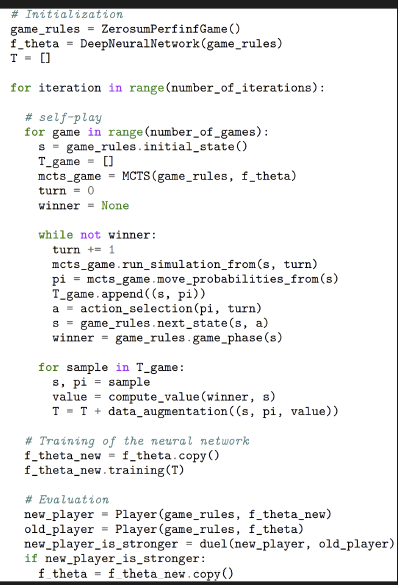

## ZEROSUMPERFINFOGAME:
It has the game rules, functions:
* initial_state() -> s
* next_state(s,a) -> s'
* game_phase(s) -> winner

Model:
* __init__ con le game rules
* copy()
* training(self_played_games) where the games are [list of states, prob. over moves, who won at the end]

MCTS:
* run_simulation(state, turn) = search. Do it like 1600 times
* move_probabilities_from(state) = what here is returned by search

action_selection(probabilities) = selects one of the actions, here we also use temperature

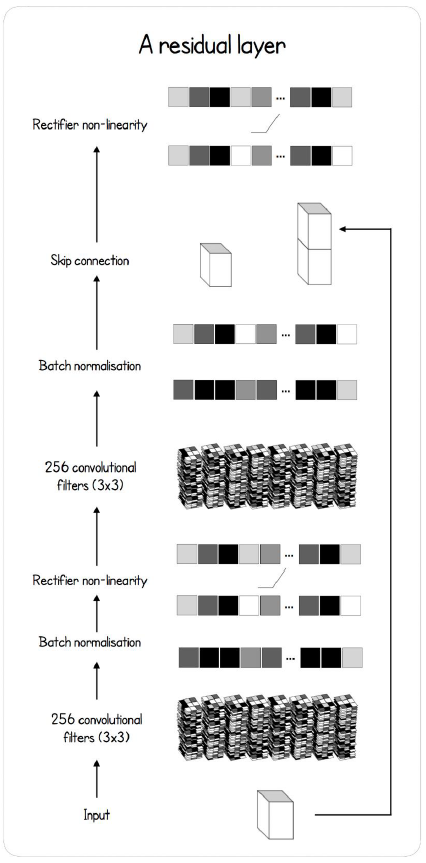